In [ ]:
!pip install git+https://github.com/rtqichen/torchdiffeq

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-3794191s
  Created wheel for torchdiffeq: filename=torchdiffeq-0.1.1-py3-none-any.whl size=28854 sha256=428a5de4ed91398a68676d2c076c9da0b362eab168ab4bc44dfa6ee63fbdf258
  Stored in directory: /tmp/pip-ephem-wheel-cache-jjnz1w9x/wheels/42/b5/d4/aeb3622995bff5e90fcc0c0ef799a6951e48daaf17e293281e
Successfully built torchdiffeq
You should consider upgrading via the '/home/jupyter/anaconda3/bin/python -m pip install --upgrade pip' command.


Please upload:


*   ode_const_20_multiclass_vpn_x_train.npy
*   ode_const_20_multiclass_vpn_x_val.npy
*   ode_const_20_multiclass_vpn_y_train.npy
*   ode_const_20_multiclass_vpn_y_val.npy








# Import Libraries

comments:
1. Add relu, dropout, subsamling?, conv?, bidirectional
2. Compare to standard nets
3. For i in range(samples_per_epoch)
4. Add recurent layer after ode

In [ ]:
import numpy as np
import random

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset

import torch.optim as optim
import torch.nn as nn

from torchdiffeq import odeint_adjoint as odeint

import os

# Define Parameters

In [ ]:
epochs = 40
samples_per_epoch = 1000
batch_size = 1  ###########################
# learning_rate = 1e-4

learning_rate = 0.01
device = torch.device("cpu")

num_classes = 4
class_names = ["VoIP", "Video", "File_Transfer", "Chat"] #ordered

seq_size = 20
input_dim = 1
bidirectional = False
lstm_num_layers = 1

tol = 1e-3
ode_hidden_dim = 32

MODEL_NAME = "40e_ode_const_20_multiclass_vpn"
PATH_PREFIX = "ode_const_20_multiclass_"

# Import Train and Validation Data

In [ ]:
data_train = np.load(PATH_PREFIX + "vpn_x_train.npy")
y_train = np.load(PATH_PREFIX + "vpn_y_train.npy")
data_val = np.load(PATH_PREFIX + "vpn_x_val.npy")
y_val = np.load(PATH_PREFIX + "vpn_y_val.npy")


print(data_train.shape, y_train.shape)
print(data_val.shape, y_val.shape)

(10050, 2, 20) (10050,)
(946, 2, 20) (946,)


In [ ]:
from sklearn.utils import shuffle
data_train, y_train = shuffle(data_train, y_train)
data_val, y_val = shuffle(data_val, y_val)

print(y_val[:100])

[2. 0. 2. 0. 1. 0. 1. 1. 0. 2. 2. 1. 1. 0. 1. 1. 2. 0. 1. 2. 2. 0. 2. 1.
 1. 2. 1. 0. 0. 2. 0. 0. 1. 1. 1. 3. 3. 0. 0. 2. 0. 0. 1. 0. 0. 0. 2. 0.
 0. 3. 1. 1. 0. 2. 2. 2. 3. 2. 0. 0. 2. 0. 1. 0. 0. 0. 2. 0. 1. 1. 0. 1.
 1. 3. 2. 2. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 3. 1. 0. 0. 3. 1. 1. 3. 2.
 1. 1. 1. 3.]


## Generate train and test sets

In [ ]:
x_train = torch.from_numpy(data_train[:,0,:].reshape((data_train.shape[0], data_train.shape[2], 1))).float()  #.float()
t_train = torch.from_numpy(data_train[:,1,:]).float()

x_val = torch.from_numpy(data_val[:,0,:].reshape((data_val.shape[0], data_val.shape[2], 1))).float()
t_val = torch.from_numpy(data_val[:,1,:]).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
                         
print(x_train.shape, t_train.shape, y_train.shape)
print(x_val.shape, t_val.shape, y_val.shape)

torch.Size([10050, 20, 1]) torch.Size([10050, 20]) torch.Size([10050])
torch.Size([946, 20, 1]) torch.Size([946, 20]) torch.Size([946])


In [ ]:
MTU = 1500
x_train = (x_train - MTU/2)/MTU
x_val = (x_val - MTU/2)/MTU
print(x_val[0:2])

tensor([[[-0.4653],
         [-0.4520],
         [-0.4653],
         [-0.4653],
         [-0.4653],
         [-0.4653],
         [-0.4653],
         [-0.4653],
         [-0.4627],
         [-0.4653],
         [-0.4653],
         [-0.4520],
         [-0.4520],
         [-0.4653],
         [-0.4653],
         [-0.4627],
         [-0.4520],
         [-0.4520],
         [-0.4520],
         [-0.4627]],

        [[-0.4107],
         [-0.4120],
         [-0.4080],
         [-0.4067],
         [-0.4107],
         [-0.4100],
         [-0.4087],
         [-0.4080],
         [-0.4507],
         [-0.4120],
         [-0.4087],
         [-0.4093],
         [-0.4113],
         [-0.4067],
         [-0.4080],
         [-0.4080],
         [-0.4127],
         [-0.4080],
         [-0.4120],
         [-0.4067]]])


In [ ]:
m1 = 0
mask1 = []
for i, ts in enumerate(t_train):
    if not np.all(np.diff(ts) > 0):
        m1 += 1
    else:
        mask1.append(i)
        
m2 = 0
mask2 = []
for i, ts in enumerate(t_val):
    if not np.all(np.diff(ts) > 0):
        m2 += 1
    else:
        mask2.append(i)
        
print(m1, m2)

2919 161


In [ ]:
x_train, t_train, y_train = x_train[mask1], t_train[mask1], y_train[mask1]
x_val, t_val, y_val = x_val[mask2], t_val[mask2], y_val[mask2]

print(x_train.shape, t_train.shape, y_train.shape)
print(x_val.shape, t_val.shape, y_val.shape)

torch.Size([7131, 20, 1]) torch.Size([7131, 20]) torch.Size([7131])
torch.Size([785, 20, 1]) torch.Size([785, 20]) torch.Size([785])


In [ ]:
def check_for_None(x, t, y):
  for i in range(len(x)):
    if True in torch.isnan(x[i]):
      print(i, x[i])
    if True in torch.isnan(t[i]):
      print(i, t[i])
    if len(x[i]) != len(t[i]):
      print(i, x[i], t[i])
    if True in torch.isnan(y[i]):
      print(i, y[i])

check_for_None(x_train, t_train, y_train)
check_for_None(x_val, t_val, y_val)

In [ ]:
train_set = TensorDataset(x_train, t_train, y_train)
test_set = TensorDataset(x_val, t_val, y_val)

## Define Loaders

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1,drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1,drop_last=True)

# Define Model

In [ ]:
class ODEFunc(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
        return self.net(x)

In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, seq_size, hidden_dim, label_size, batch_size, bidirectional, num_layers, ode_func):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.hidden = self.init_hidden()
        
        self.ode_func = ode_func
        
        self.fc = nn.Linear(hidden_dim*seq_size, 128)
        if bidirectional:
            self.fc = nn.Linear(2*hidden_dim*seq_size, 128)
        self.hidden2label = nn.Linear(128, label_size)
        

    def init_hidden(self):
        first_size = 1
        if self.bidirectional:
            first_size = 2
        h0 = Variable(torch.zeros(first_size*self.num_layers, self.batch_size, self.hidden_dim)).float()
        c0 = Variable(torch.zeros(first_size*self.num_layers, self.batch_size, self.hidden_dim)).float()
        return (h0, c0)

    def forward(self, x, t):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
#         print(lstm_out.shape)
#         print(lstm_out.shape[1], lstm_out.shape[2], self.seq_size, self.hidden_dim)
#         print(lstm_out.shape, lstm_out[:,0,:].shape, t.shape)
        out = odeint(self.ode_func, lstm_out[:,0,:], t[0], rtol=tol, atol=tol)
#         print(out.shape)
        out = out.view(lstm_out.shape)
#         print(out.shape)
        out = out.contiguous().view(-1, lstm_out.shape[1]*lstm_out.shape[2])  #contiguous() ###TTS##
#         print(out.shape)
#         print(lstm_out.shape)
#         print(lstm_out.shape)
#         lstm_out = torch.squeeze(lstm_out)
#         print(lstm_out.shape)
        y = self.fc(out)
        y = F.relu(y)
        y = self.hidden2label(y)
#         print(y.shape)
        return y
    
    ## For Regular LSTM
    #def forward(self, x):
     #   lstm_out, self.hidden = self.lstm(x, self.hidden)
      #  lstm_out = torch.squeeze(lstm_out)
       # y = self.fc(lstm_out)
        #y = self.hidden2label(y)
        #return y

In [ ]:
ode_func = ODEFunc(input_dim, ode_hidden_dim)
if bidirectional:
    ode_func = ODEFunc(input_dim*2, ode_hidden_dim)
model = LSTMClassifier(input_dim, seq_size, input_dim, num_classes, batch_size, bidirectional, lstm_num_layers, ode_func).to(device)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print('Number of parameters: {}'.format(count_parameters(model)))

LSTMClassifier(
  (lstm): LSTM(1, 1, batch_first=True)
  (ode_func): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=20, out_features=128, bias=True)
  (hidden2label): Linear(in_features=128, out_features=4, bias=True)
)
Number of parameters: 3317


# Run model

## Define train and test functions

In [ ]:
def train(model, device, train_loader, optimizer, loss_function, epoch):
    model.train()
    correct = 0
    for batch_idx, traindata in enumerate(train_loader):
        x, t, target = traindata
        x, t, target = x.to(device), t.to(device), target.to(device)
        optimizer.zero_grad()
        model.hidden = model.init_hidden()
        output = model(x, t)
        output = torch.reshape(output, (batch_size, num_classes)) ######
        # train accuracy
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        ##

#         print(output.shape, target.shape)
        loss = loss_function(output, target)
#         if batch_idx == 0:
#             loss.backward(retain_graph=True)
#         else:
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0: #%10
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(target), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    print('\nTrain set: Accuracy: {}/{} ({:.2f}%)\n'.format(
            correct, len(train_loader.dataset),100. * correct / len(train_loader.dataset)))
    train_acc=100. * correct / len(train_loader.dataset)
    return train_acc

def test(model, device, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, t, target in test_loader:
            x, t, target = x.to(device), t.to(device), target.to(device)
            output = model(x, t)
            output = torch.reshape(output, (batch_size, num_classes)) #######
            test_loss += loss_function(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=(100. * correct / len(test_loader.dataset))
    return test_loss,test_acc


In [ ]:
epoch_array=[]
accuracy_array=[]
train_accuracy_array=[]
best_acc = 0
#test_loss = 0
patience,trials =100, 0
for epoch in range(1, epochs + 1):
    adjust_learning_rate(optimizer, epoch)
   # train(model, device, train_loader, optimizer, loss_function, epoch)
    tr_acc=train(model, device, train_loader, optimizer, loss_function, epoch)
    loss,acc=test(model, device, test_loader, loss_function)
    
    epoch_array.append(epoch)
    accuracy_array.append(acc)
    train_accuracy_array.append(tr_acc)
    print(f'DEBUG pre accuracy {acc}, best accuracy {best_acc}')
    if (acc > best_acc):
        best_acc = acc
        torch.save(model.state_dict(), '40e_multiclass_ode.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
    print(f'DEBUG post accuracy {acc}, best accuracy {best_acc}')

Train Epoch: 1 [0/7131 (0%)]	Loss: 1.395470
Train Epoch: 1 [100/7131 (1%)]	Loss: 1.478421
Train Epoch: 1 [200/7131 (3%)]	Loss: 0.985667
Train Epoch: 1 [300/7131 (4%)]	Loss: 1.606446
Train Epoch: 1 [400/7131 (6%)]	Loss: 2.803173
Train Epoch: 1 [500/7131 (7%)]	Loss: 1.619396
Train Epoch: 1 [600/7131 (8%)]	Loss: 0.974119
Train Epoch: 1 [700/7131 (10%)]	Loss: 1.274945
Train Epoch: 1 [800/7131 (11%)]	Loss: 1.146707
Train Epoch: 1 [900/7131 (13%)]	Loss: 0.739208
Train Epoch: 1 [1000/7131 (14%)]	Loss: 0.702679
Train Epoch: 1 [1100/7131 (15%)]	Loss: 1.188243
Train Epoch: 1 [1200/7131 (17%)]	Loss: 1.107970
Train Epoch: 1 [1300/7131 (18%)]	Loss: 1.174624
Train Epoch: 1 [1400/7131 (20%)]	Loss: 0.595001
Train Epoch: 1 [1500/7131 (21%)]	Loss: 7.107163
Train Epoch: 1 [1600/7131 (22%)]	Loss: 1.074852
Train Epoch: 1 [1700/7131 (24%)]	Loss: 1.475897
Train Epoch: 1 [1800/7131 (25%)]	Loss: 0.754475
Train Epoch: 1 [1900/7131 (27%)]	Loss: 0.979163
Train Epoch: 1 [2000/7131 (28%)]	Loss: 0.698007
Train Epoch

Train Epoch: 3 [1600/7131 (22%)]	Loss: 0.789807
Train Epoch: 3 [1700/7131 (24%)]	Loss: 0.763674
Train Epoch: 3 [1800/7131 (25%)]	Loss: 0.047456
Train Epoch: 3 [1900/7131 (27%)]	Loss: 0.571315
Train Epoch: 3 [2000/7131 (28%)]	Loss: 1.499801
Train Epoch: 3 [2100/7131 (29%)]	Loss: 0.195200
Train Epoch: 3 [2200/7131 (31%)]	Loss: 0.838419
Train Epoch: 3 [2300/7131 (32%)]	Loss: 0.068037
Train Epoch: 3 [2400/7131 (34%)]	Loss: 0.603743
Train Epoch: 3 [2500/7131 (35%)]	Loss: 0.494424
Train Epoch: 3 [2600/7131 (36%)]	Loss: 0.030245
Train Epoch: 3 [2700/7131 (38%)]	Loss: 0.182875
Train Epoch: 3 [2800/7131 (39%)]	Loss: 1.254194
Train Epoch: 3 [2900/7131 (41%)]	Loss: 0.572238
Train Epoch: 3 [3000/7131 (42%)]	Loss: 0.834204
Train Epoch: 3 [3100/7131 (43%)]	Loss: 1.844481
Train Epoch: 3 [3200/7131 (45%)]	Loss: 0.158342
Train Epoch: 3 [3300/7131 (46%)]	Loss: 0.021383
Train Epoch: 3 [3400/7131 (48%)]	Loss: 0.710805
Train Epoch: 3 [3500/7131 (49%)]	Loss: 0.027292
Train Epoch: 3 [3600/7131 (50%)]	Loss: 0

Train Epoch: 5 [3400/7131 (48%)]	Loss: 0.579406
Train Epoch: 5 [3500/7131 (49%)]	Loss: 0.688698
Train Epoch: 5 [3600/7131 (50%)]	Loss: 0.660626
Train Epoch: 5 [3700/7131 (52%)]	Loss: 0.563962
Train Epoch: 5 [3800/7131 (53%)]	Loss: 0.176089
Train Epoch: 5 [3900/7131 (55%)]	Loss: 2.817471
Train Epoch: 5 [4000/7131 (56%)]	Loss: 0.469953
Train Epoch: 5 [4100/7131 (57%)]	Loss: 0.025680
Train Epoch: 5 [4200/7131 (59%)]	Loss: 0.024173
Train Epoch: 5 [4300/7131 (60%)]	Loss: 0.591696
Train Epoch: 5 [4400/7131 (62%)]	Loss: 0.029180
Train Epoch: 5 [4500/7131 (63%)]	Loss: 0.521471
Train Epoch: 5 [4600/7131 (65%)]	Loss: 0.875874
Train Epoch: 5 [4700/7131 (66%)]	Loss: 0.226477
Train Epoch: 5 [4800/7131 (67%)]	Loss: 0.137361
Train Epoch: 5 [4900/7131 (69%)]	Loss: 0.015575
Train Epoch: 5 [5000/7131 (70%)]	Loss: 0.801308
Train Epoch: 5 [5100/7131 (72%)]	Loss: 3.446596
Train Epoch: 5 [5200/7131 (73%)]	Loss: 0.025394
Train Epoch: 5 [5300/7131 (74%)]	Loss: 0.037020
Train Epoch: 5 [5400/7131 (76%)]	Loss: 0

Train Epoch: 7 [5200/7131 (73%)]	Loss: 0.022638
Train Epoch: 7 [5300/7131 (74%)]	Loss: 0.029346
Train Epoch: 7 [5400/7131 (76%)]	Loss: 0.018492
Train Epoch: 7 [5500/7131 (77%)]	Loss: 0.665678
Train Epoch: 7 [5600/7131 (79%)]	Loss: 0.784626
Train Epoch: 7 [5700/7131 (80%)]	Loss: 0.018900
Train Epoch: 7 [5800/7131 (81%)]	Loss: 0.945927
Train Epoch: 7 [5900/7131 (83%)]	Loss: 0.055923
Train Epoch: 7 [6000/7131 (84%)]	Loss: 0.619127
Train Epoch: 7 [6100/7131 (86%)]	Loss: 0.132268
Train Epoch: 7 [6200/7131 (87%)]	Loss: 0.016706
Train Epoch: 7 [6300/7131 (88%)]	Loss: 0.741842
Train Epoch: 7 [6400/7131 (90%)]	Loss: 0.018847
Train Epoch: 7 [6500/7131 (91%)]	Loss: 0.492806
Train Epoch: 7 [6600/7131 (93%)]	Loss: 0.800965
Train Epoch: 7 [6700/7131 (94%)]	Loss: 0.916833
Train Epoch: 7 [6800/7131 (95%)]	Loss: 0.599117
Train Epoch: 7 [6900/7131 (97%)]	Loss: 1.039356
Train Epoch: 7 [7000/7131 (98%)]	Loss: 0.609832
Train Epoch: 7 [7100/7131 (100%)]	Loss: 0.012630

Train set: Accuracy: 5325/7131 (74.67%

Train Epoch: 9 [6700/7131 (94%)]	Loss: 0.012899
Train Epoch: 9 [6800/7131 (95%)]	Loss: 1.055569
Train Epoch: 9 [6900/7131 (97%)]	Loss: 0.118662
Train Epoch: 9 [7000/7131 (98%)]	Loss: 0.896721
Train Epoch: 9 [7100/7131 (100%)]	Loss: 0.039483

Train set: Accuracy: 5337/7131 (74.84%)


Test set: Average loss: 0.7495, Test Accuracy: 593/785 (75.54%)

DEBUG pre accuracy 75.54140127388536, best accuracy 80.38216560509554
DEBUG post accuracy 75.54140127388536, best accuracy 80.38216560509554
Train Epoch: 10 [0/7131 (0%)]	Loss: 0.016710
Train Epoch: 10 [100/7131 (1%)]	Loss: 0.028717
Train Epoch: 10 [200/7131 (3%)]	Loss: 1.612971
Train Epoch: 10 [300/7131 (4%)]	Loss: 0.039980
Train Epoch: 10 [400/7131 (6%)]	Loss: 0.592904
Train Epoch: 10 [500/7131 (7%)]	Loss: 0.601734
Train Epoch: 10 [600/7131 (8%)]	Loss: 0.037847
Train Epoch: 10 [700/7131 (10%)]	Loss: 0.594189
Train Epoch: 10 [800/7131 (11%)]	Loss: 0.027667
Train Epoch: 10 [900/7131 (13%)]	Loss: 0.013027
Train Epoch: 10 [1000/7131 (14%)]	Loss:

Train Epoch: 12 [400/7131 (6%)]	Loss: 0.674639
Train Epoch: 12 [500/7131 (7%)]	Loss: 0.011986
Train Epoch: 12 [600/7131 (8%)]	Loss: 0.010243
Train Epoch: 12 [700/7131 (10%)]	Loss: 0.606111
Train Epoch: 12 [800/7131 (11%)]	Loss: 2.739533
Train Epoch: 12 [900/7131 (13%)]	Loss: 0.465503
Train Epoch: 12 [1000/7131 (14%)]	Loss: 0.714870
Train Epoch: 12 [1100/7131 (15%)]	Loss: 0.010169
Train Epoch: 12 [1200/7131 (17%)]	Loss: 0.240407
Train Epoch: 12 [1300/7131 (18%)]	Loss: 0.009780
Train Epoch: 12 [1400/7131 (20%)]	Loss: 0.597291
Train Epoch: 12 [1500/7131 (21%)]	Loss: 0.602344
Train Epoch: 12 [1600/7131 (22%)]	Loss: 0.010337
Train Epoch: 12 [1700/7131 (24%)]	Loss: 0.010031
Train Epoch: 12 [1800/7131 (25%)]	Loss: 0.011826
Train Epoch: 12 [1900/7131 (27%)]	Loss: 0.109294
Train Epoch: 12 [2000/7131 (28%)]	Loss: 0.759125
Train Epoch: 12 [2100/7131 (29%)]	Loss: 0.772265
Train Epoch: 12 [2200/7131 (31%)]	Loss: 0.039360
Train Epoch: 12 [2300/7131 (32%)]	Loss: 0.011694
Train Epoch: 12 [2400/7131 (3

Train Epoch: 14 [1800/7131 (25%)]	Loss: 0.642929
Train Epoch: 14 [1900/7131 (27%)]	Loss: 0.025715
Train Epoch: 14 [2000/7131 (28%)]	Loss: 0.011320
Train Epoch: 14 [2100/7131 (29%)]	Loss: 0.497520
Train Epoch: 14 [2200/7131 (31%)]	Loss: 0.010174
Train Epoch: 14 [2300/7131 (32%)]	Loss: 0.803354
Train Epoch: 14 [2400/7131 (34%)]	Loss: 1.224792
Train Epoch: 14 [2500/7131 (35%)]	Loss: 0.755927
Train Epoch: 14 [2600/7131 (36%)]	Loss: 1.005017
Train Epoch: 14 [2700/7131 (38%)]	Loss: 0.015731
Train Epoch: 14 [2800/7131 (39%)]	Loss: 0.700139
Train Epoch: 14 [2900/7131 (41%)]	Loss: 0.014082
Train Epoch: 14 [3000/7131 (42%)]	Loss: 0.013283
Train Epoch: 14 [3100/7131 (43%)]	Loss: 0.014395
Train Epoch: 14 [3200/7131 (45%)]	Loss: 0.013001
Train Epoch: 14 [3300/7131 (46%)]	Loss: 0.628332
Train Epoch: 14 [3400/7131 (48%)]	Loss: 0.013137
Train Epoch: 14 [3500/7131 (49%)]	Loss: 1.076948
Train Epoch: 14 [3600/7131 (50%)]	Loss: 0.019613
Train Epoch: 14 [3700/7131 (52%)]	Loss: 0.013609
Train Epoch: 14 [380

Train Epoch: 16 [3200/7131 (45%)]	Loss: 0.011324
Train Epoch: 16 [3300/7131 (46%)]	Loss: 0.683761
Train Epoch: 16 [3400/7131 (48%)]	Loss: 0.009705
Train Epoch: 16 [3500/7131 (49%)]	Loss: 0.038524
Train Epoch: 16 [3600/7131 (50%)]	Loss: 0.010559
Train Epoch: 16 [3700/7131 (52%)]	Loss: 0.750039
Train Epoch: 16 [3800/7131 (53%)]	Loss: 0.252606
Train Epoch: 16 [3900/7131 (55%)]	Loss: 0.660074
Train Epoch: 16 [4000/7131 (56%)]	Loss: 0.011518
Train Epoch: 16 [4100/7131 (57%)]	Loss: 0.011676
Train Epoch: 16 [4200/7131 (59%)]	Loss: 0.011233
Train Epoch: 16 [4300/7131 (60%)]	Loss: 0.710594
Train Epoch: 16 [4400/7131 (62%)]	Loss: 0.055560
Train Epoch: 16 [4500/7131 (63%)]	Loss: 0.716862
Train Epoch: 16 [4600/7131 (65%)]	Loss: 0.011789
Train Epoch: 16 [4700/7131 (66%)]	Loss: 0.901580
Train Epoch: 16 [4800/7131 (67%)]	Loss: 0.010604
Train Epoch: 16 [4900/7131 (69%)]	Loss: 0.010470
Train Epoch: 16 [5000/7131 (70%)]	Loss: 0.010016
Train Epoch: 16 [5100/7131 (72%)]	Loss: 0.711250
Train Epoch: 16 [520

Train Epoch: 18 [4600/7131 (65%)]	Loss: 0.029869
Train Epoch: 18 [4700/7131 (66%)]	Loss: 0.599438
Train Epoch: 18 [4800/7131 (67%)]	Loss: 0.640162
Train Epoch: 18 [4900/7131 (69%)]	Loss: 0.010192
Train Epoch: 18 [5000/7131 (70%)]	Loss: 0.010936
Train Epoch: 18 [5100/7131 (72%)]	Loss: 0.010296
Train Epoch: 18 [5200/7131 (73%)]	Loss: 0.736071
Train Epoch: 18 [5300/7131 (74%)]	Loss: 1.392628
Train Epoch: 18 [5400/7131 (76%)]	Loss: 0.638229
Train Epoch: 18 [5500/7131 (77%)]	Loss: 0.010418
Train Epoch: 18 [5600/7131 (79%)]	Loss: 0.011121
Train Epoch: 18 [5700/7131 (80%)]	Loss: 0.648509
Train Epoch: 18 [5800/7131 (81%)]	Loss: 0.009933
Train Epoch: 18 [5900/7131 (83%)]	Loss: 0.046101
Train Epoch: 18 [6000/7131 (84%)]	Loss: 0.030727
Train Epoch: 18 [6100/7131 (86%)]	Loss: 0.722988
Train Epoch: 18 [6200/7131 (87%)]	Loss: 1.220832
Train Epoch: 18 [6300/7131 (88%)]	Loss: 0.683385
Train Epoch: 18 [6400/7131 (90%)]	Loss: 0.010808
Train Epoch: 18 [6500/7131 (91%)]	Loss: 0.523486
Train Epoch: 18 [660

Train Epoch: 20 [6000/7131 (84%)]	Loss: 0.010052
Train Epoch: 20 [6100/7131 (86%)]	Loss: 0.645578
Train Epoch: 20 [6200/7131 (87%)]	Loss: 0.077031
Train Epoch: 20 [6300/7131 (88%)]	Loss: 0.753190
Train Epoch: 20 [6400/7131 (90%)]	Loss: 0.009610
Train Epoch: 20 [6500/7131 (91%)]	Loss: 0.009876
Train Epoch: 20 [6600/7131 (93%)]	Loss: 0.010042
Train Epoch: 20 [6700/7131 (94%)]	Loss: 0.010749
Train Epoch: 20 [6800/7131 (95%)]	Loss: 0.759224
Train Epoch: 20 [6900/7131 (97%)]	Loss: 0.720286
Train Epoch: 20 [7000/7131 (98%)]	Loss: 0.652627
Train Epoch: 20 [7100/7131 (100%)]	Loss: 0.731021

Train set: Accuracy: 5474/7131 (76.76%)


Test set: Average loss: 0.5847, Test Accuracy: 559/785 (71.21%)

DEBUG pre accuracy 71.21019108280255, best accuracy 80.38216560509554
DEBUG post accuracy 71.21019108280255, best accuracy 80.38216560509554
Train Epoch: 21 [0/7131 (0%)]	Loss: 0.712203
Train Epoch: 21 [100/7131 (1%)]	Loss: 0.653930
Train Epoch: 21 [200/7131 (3%)]	Loss: 1.735269
Train Epoch: 21 [300/71

Train Epoch: 23 [0/7131 (0%)]	Loss: 0.740622
Train Epoch: 23 [100/7131 (1%)]	Loss: 0.010050
Train Epoch: 23 [200/7131 (3%)]	Loss: 0.662932
Train Epoch: 23 [300/7131 (4%)]	Loss: 0.009477
Train Epoch: 23 [400/7131 (6%)]	Loss: 0.009791
Train Epoch: 23 [500/7131 (7%)]	Loss: 0.656043
Train Epoch: 23 [600/7131 (8%)]	Loss: 0.009974
Train Epoch: 23 [700/7131 (10%)]	Loss: 0.031360
Train Epoch: 23 [800/7131 (11%)]	Loss: 0.098762
Train Epoch: 23 [900/7131 (13%)]	Loss: 0.010073
Train Epoch: 23 [1000/7131 (14%)]	Loss: 0.010175
Train Epoch: 23 [1100/7131 (15%)]	Loss: 0.729671
Train Epoch: 23 [1200/7131 (17%)]	Loss: 0.664185
Train Epoch: 23 [1300/7131 (18%)]	Loss: 0.024971
Train Epoch: 23 [1400/7131 (20%)]	Loss: 0.011012
Train Epoch: 23 [1500/7131 (21%)]	Loss: 0.009849
Train Epoch: 23 [1600/7131 (22%)]	Loss: 0.009593
Train Epoch: 23 [1700/7131 (24%)]	Loss: 0.009592
Train Epoch: 23 [1800/7131 (25%)]	Loss: 0.011649
Train Epoch: 23 [1900/7131 (27%)]	Loss: 0.739259
Train Epoch: 23 [2000/7131 (28%)]	Loss:

Train Epoch: 25 [1500/7131 (21%)]	Loss: 0.504337
Train Epoch: 25 [1600/7131 (22%)]	Loss: 0.659345
Train Epoch: 25 [1700/7131 (24%)]	Loss: 0.055021
Train Epoch: 25 [1800/7131 (25%)]	Loss: 0.665831
Train Epoch: 25 [1900/7131 (27%)]	Loss: 0.668223
Train Epoch: 25 [2000/7131 (28%)]	Loss: 0.009044
Train Epoch: 25 [2100/7131 (29%)]	Loss: 0.675156
Train Epoch: 25 [2200/7131 (31%)]	Loss: 0.010909
Train Epoch: 25 [2300/7131 (32%)]	Loss: 0.009989
Train Epoch: 25 [2400/7131 (34%)]	Loss: 0.087414
Train Epoch: 25 [2500/7131 (35%)]	Loss: 0.665826
Train Epoch: 25 [2600/7131 (36%)]	Loss: 0.009276
Train Epoch: 25 [2700/7131 (38%)]	Loss: 5.110257
Train Epoch: 25 [2800/7131 (39%)]	Loss: 0.010598
Train Epoch: 25 [2900/7131 (41%)]	Loss: 0.021470
Train Epoch: 25 [3000/7131 (42%)]	Loss: 0.010097
Train Epoch: 25 [3100/7131 (43%)]	Loss: 0.014801
Train Epoch: 25 [3200/7131 (45%)]	Loss: 0.535799
Train Epoch: 25 [3300/7131 (46%)]	Loss: 0.852088
Train Epoch: 25 [3400/7131 (48%)]	Loss: 0.728005
Train Epoch: 25 [350

Train Epoch: 27 [2900/7131 (41%)]	Loss: 0.716945
Train Epoch: 27 [3000/7131 (42%)]	Loss: 0.010177
Train Epoch: 27 [3100/7131 (43%)]	Loss: 0.147310
Train Epoch: 27 [3200/7131 (45%)]	Loss: 0.538329
Train Epoch: 27 [3300/7131 (46%)]	Loss: 0.399132
Train Epoch: 27 [3400/7131 (48%)]	Loss: 0.009773
Train Epoch: 27 [3500/7131 (49%)]	Loss: 0.694081
Train Epoch: 27 [3600/7131 (50%)]	Loss: 0.018350
Train Epoch: 27 [3700/7131 (52%)]	Loss: 0.714065
Train Epoch: 27 [3800/7131 (53%)]	Loss: 0.022956
Train Epoch: 27 [3900/7131 (55%)]	Loss: 0.495472
Train Epoch: 27 [4000/7131 (56%)]	Loss: 0.033770
Train Epoch: 27 [4100/7131 (57%)]	Loss: 0.010265
Train Epoch: 27 [4200/7131 (59%)]	Loss: 0.010900
Train Epoch: 27 [4300/7131 (60%)]	Loss: 0.740586
Train Epoch: 27 [4400/7131 (62%)]	Loss: 0.390182
Train Epoch: 27 [4500/7131 (63%)]	Loss: 0.688182
Train Epoch: 27 [4600/7131 (65%)]	Loss: 0.579747
Train Epoch: 27 [4700/7131 (66%)]	Loss: 0.674152
Train Epoch: 27 [4800/7131 (67%)]	Loss: 0.933881
Train Epoch: 27 [490

Train Epoch: 29 [4300/7131 (60%)]	Loss: 0.739619
Train Epoch: 29 [4400/7131 (62%)]	Loss: 0.009981
Train Epoch: 29 [4500/7131 (63%)]	Loss: 0.014785
Train Epoch: 29 [4600/7131 (65%)]	Loss: 0.010450
Train Epoch: 29 [4700/7131 (66%)]	Loss: 0.012919
Train Epoch: 29 [4800/7131 (67%)]	Loss: 0.010735
Train Epoch: 29 [4900/7131 (69%)]	Loss: 0.010199
Train Epoch: 29 [5000/7131 (70%)]	Loss: 0.708521
Train Epoch: 29 [5100/7131 (72%)]	Loss: 0.382841
Train Epoch: 29 [5200/7131 (73%)]	Loss: 0.010644
Train Epoch: 29 [5300/7131 (74%)]	Loss: 0.009564
Train Epoch: 29 [5400/7131 (76%)]	Loss: 0.171295
Train Epoch: 29 [5500/7131 (77%)]	Loss: 0.660526
Train Epoch: 29 [5600/7131 (79%)]	Loss: 1.801828
Train Epoch: 29 [5700/7131 (80%)]	Loss: 0.169740
Train Epoch: 29 [5800/7131 (81%)]	Loss: 0.013672
Train Epoch: 29 [5900/7131 (83%)]	Loss: 0.670402
Train Epoch: 29 [6000/7131 (84%)]	Loss: 0.684492
Train Epoch: 29 [6100/7131 (86%)]	Loss: 0.685185
Train Epoch: 29 [6200/7131 (87%)]	Loss: 0.009780
Train Epoch: 29 [630

Train Epoch: 31 [5700/7131 (80%)]	Loss: 0.010125
Train Epoch: 31 [5800/7131 (81%)]	Loss: 0.073408
Train Epoch: 31 [5900/7131 (83%)]	Loss: 0.009922
Train Epoch: 31 [6000/7131 (84%)]	Loss: 1.893743
Train Epoch: 31 [6100/7131 (86%)]	Loss: 0.432033
Train Epoch: 31 [6200/7131 (87%)]	Loss: 0.009893
Train Epoch: 31 [6300/7131 (88%)]	Loss: 0.015335
Train Epoch: 31 [6400/7131 (90%)]	Loss: 0.009691
Train Epoch: 31 [6500/7131 (91%)]	Loss: 0.010395
Train Epoch: 31 [6600/7131 (93%)]	Loss: 0.663648
Train Epoch: 31 [6700/7131 (94%)]	Loss: 0.399842
Train Epoch: 31 [6800/7131 (95%)]	Loss: 0.663485
Train Epoch: 31 [6900/7131 (97%)]	Loss: 0.009932
Train Epoch: 31 [7000/7131 (98%)]	Loss: 0.734133
Train Epoch: 31 [7100/7131 (100%)]	Loss: 0.009558

Train set: Accuracy: 5539/7131 (77.67%)


Test set: Average loss: 0.5959, Test Accuracy: 557/785 (70.96%)

DEBUG pre accuracy 70.95541401273886, best accuracy 80.38216560509554
DEBUG post accuracy 70.95541401273886, best accuracy 80.38216560509554
Train Epoch: 32

Train Epoch: 33 [7100/7131 (100%)]	Loss: 0.009552

Train set: Accuracy: 5523/7131 (77.45%)


Test set: Average loss: 0.5940, Test Accuracy: 556/785 (70.83%)

DEBUG pre accuracy 70.828025477707, best accuracy 80.38216560509554
DEBUG post accuracy 70.828025477707, best accuracy 80.38216560509554
Train Epoch: 34 [0/7131 (0%)]	Loss: 0.631084
Train Epoch: 34 [100/7131 (1%)]	Loss: 0.732696
Train Epoch: 34 [200/7131 (3%)]	Loss: 0.641361
Train Epoch: 34 [300/7131 (4%)]	Loss: 0.110427
Train Epoch: 34 [400/7131 (6%)]	Loss: 0.016913
Train Epoch: 34 [500/7131 (7%)]	Loss: 0.011204
Train Epoch: 34 [600/7131 (8%)]	Loss: 0.013427
Train Epoch: 34 [700/7131 (10%)]	Loss: 1.044809
Train Epoch: 34 [800/7131 (11%)]	Loss: 0.009586
Train Epoch: 34 [900/7131 (13%)]	Loss: 0.419321
Train Epoch: 34 [1000/7131 (14%)]	Loss: 0.728147
Train Epoch: 34 [1100/7131 (15%)]	Loss: 0.669135
Train Epoch: 34 [1200/7131 (17%)]	Loss: 0.807785
Train Epoch: 34 [1300/7131 (18%)]	Loss: 0.009991
Train Epoch: 34 [1400/7131 (20%)]	Loss

Train Epoch: 36 [900/7131 (13%)]	Loss: 0.028992
Train Epoch: 36 [1000/7131 (14%)]	Loss: 0.723072
Train Epoch: 36 [1100/7131 (15%)]	Loss: 0.662203
Train Epoch: 36 [1200/7131 (17%)]	Loss: 0.731432
Train Epoch: 36 [1300/7131 (18%)]	Loss: 0.039525
Train Epoch: 36 [1400/7131 (20%)]	Loss: 2.537700
Train Epoch: 36 [1500/7131 (21%)]	Loss: 0.675004
Train Epoch: 36 [1600/7131 (22%)]	Loss: 0.034297
Train Epoch: 36 [1700/7131 (24%)]	Loss: 0.046661
Train Epoch: 36 [1800/7131 (25%)]	Loss: 0.724320
Train Epoch: 36 [1900/7131 (27%)]	Loss: 0.009608
Train Epoch: 36 [2000/7131 (28%)]	Loss: 0.010961
Train Epoch: 36 [2100/7131 (29%)]	Loss: 0.098926
Train Epoch: 36 [2200/7131 (31%)]	Loss: 0.733991
Train Epoch: 36 [2300/7131 (32%)]	Loss: 0.009630
Train Epoch: 36 [2400/7131 (34%)]	Loss: 0.009381
Train Epoch: 36 [2500/7131 (35%)]	Loss: 1.293291
Train Epoch: 36 [2600/7131 (36%)]	Loss: 0.009537
Train Epoch: 36 [2700/7131 (38%)]	Loss: 0.010190
Train Epoch: 36 [2800/7131 (39%)]	Loss: 0.011297
Train Epoch: 36 [2900

Train Epoch: 38 [2300/7131 (32%)]	Loss: 0.670061
Train Epoch: 38 [2400/7131 (34%)]	Loss: 1.993082
Train Epoch: 38 [2500/7131 (35%)]	Loss: 0.725697
Train Epoch: 38 [2600/7131 (36%)]	Loss: 0.009618
Train Epoch: 38 [2700/7131 (38%)]	Loss: 0.009893
Train Epoch: 38 [2800/7131 (39%)]	Loss: 0.032187
Train Epoch: 38 [2900/7131 (41%)]	Loss: 0.720562
Train Epoch: 38 [3000/7131 (42%)]	Loss: 0.729291
Train Epoch: 38 [3100/7131 (43%)]	Loss: 0.010171
Train Epoch: 38 [3200/7131 (45%)]	Loss: 0.010043
Train Epoch: 38 [3300/7131 (46%)]	Loss: 0.662055
Train Epoch: 38 [3400/7131 (48%)]	Loss: 0.010548
Train Epoch: 38 [3500/7131 (49%)]	Loss: 0.730001
Train Epoch: 38 [3600/7131 (50%)]	Loss: 0.010935
Train Epoch: 38 [3700/7131 (52%)]	Loss: 0.665519
Train Epoch: 38 [3800/7131 (53%)]	Loss: 0.679027
Train Epoch: 38 [3900/7131 (55%)]	Loss: 0.010074
Train Epoch: 38 [4000/7131 (56%)]	Loss: 0.593049
Train Epoch: 38 [4100/7131 (57%)]	Loss: 0.216253
Train Epoch: 38 [4200/7131 (59%)]	Loss: 0.717634
Train Epoch: 38 [430

Train Epoch: 40 [3700/7131 (52%)]	Loss: 0.009299
Train Epoch: 40 [3800/7131 (53%)]	Loss: 0.721921
Train Epoch: 40 [3900/7131 (55%)]	Loss: 0.635057
Train Epoch: 40 [4000/7131 (56%)]	Loss: 0.077292
Train Epoch: 40 [4100/7131 (57%)]	Loss: 0.010356
Train Epoch: 40 [4200/7131 (59%)]	Loss: 0.660356
Train Epoch: 40 [4300/7131 (60%)]	Loss: 0.010019
Train Epoch: 40 [4400/7131 (62%)]	Loss: 0.049940
Train Epoch: 40 [4500/7131 (63%)]	Loss: 0.010146
Train Epoch: 40 [4600/7131 (65%)]	Loss: 0.719720
Train Epoch: 40 [4700/7131 (66%)]	Loss: 0.009674
Train Epoch: 40 [4800/7131 (67%)]	Loss: 0.010587
Train Epoch: 40 [4900/7131 (69%)]	Loss: 0.724321
Train Epoch: 40 [5000/7131 (70%)]	Loss: 0.009587
Train Epoch: 40 [5100/7131 (72%)]	Loss: 1.304143
Train Epoch: 40 [5200/7131 (73%)]	Loss: 0.732069
Train Epoch: 40 [5300/7131 (74%)]	Loss: 0.009908
Train Epoch: 40 [5400/7131 (76%)]	Loss: 0.010515
Train Epoch: 40 [5500/7131 (77%)]	Loss: 0.725634
Train Epoch: 40 [5600/7131 (79%)]	Loss: 0.707821
Train Epoch: 40 [570

In [ ]:
print('The training is finished! Restoring the best model weights')

The training is finished! Restoring the best model weights


In [ ]:
pwd

'/root/Desktop/Experiment/classes/multiclass/vpn/ode_const_20_multiclass_vpn'

In [ ]:
model.load_state_dict(torch.load('40e_multiclass_ode.pth'))
model.eval()

LSTMClassifier(
  (lstm): LSTM(1, 1, batch_first=True)
  (ode_func): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=20, out_features=128, bias=True)
  (hidden2label): Linear(in_features=128, out_features=4, bias=True)
)

### Plot history accuracy

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(epoch_array,train_accuracy_array,label = "Train accuracy")
plt.plot(epoch_array,accuracy_array,label = "Test accuracy")
plt.title("Training Curve (batch_size=1, lr=0.01)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(MODEL_NAME +  "_accuracy history", bbox_inches='tight', pad_inches=1)
plt.show()

In [ ]:

def eval(model, device, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    preds=[]
    true_labels=[]
    with torch.no_grad():
        for batch_idx,testdata in enumerate(test_loader):
            x,t,target=testdata
        #for x, t, target in test_loader:
            x, t, target = x.to(device), t.to(device), target.to(device)
            output = model(x, t)
            output = torch.reshape(output, (batch_size, num_classes)) ###########
            test_loss += loss_function(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            preds.append(pred)
            true_labels.append(target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return preds,true_labels

preds,true_labels=eval(model, device, test_loader, loss_function)


Test set: Average loss: 0.5366, Accuracy: 631/785 (80.38%)



Confusion matrix, without normalization
[[283   0  29   2]
 [  0 186   2   0]
 [  2   4  61  13]
 [  0   0 102 101]]
Normalized confusion matrix
[[0.9  0.   0.09 0.01]
 [0.   0.99 0.01 0.  ]
 [0.03 0.05 0.76 0.16]
 [0.   0.   0.5  0.5 ]]


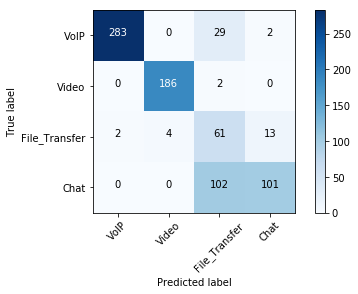

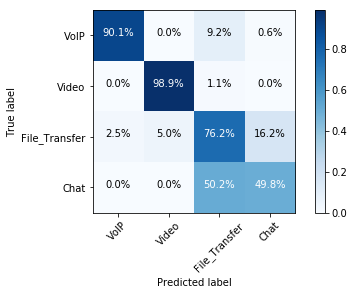

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize and cm[i, j] >= 0:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(fname, bbox_inches='tight', pad_inches=1)

# Compute confusion matrix
##cnf_matrix = confusion_matrix(y_val_true, y_val_prediction)
cnf_matrix = confusion_matrix(preds,true_labels)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',
                      fname=MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(preds,true_labels))

             precision    recall  f1-score   support

          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94       314
          0       0.99      0.90      0.94   